# Synthetic Periodic Example

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import optuna
import pandas as pd

In [4]:
import jax
import jax.numpy as jnp
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
from jax.lib import xla_bridge

In [5]:
from ffbq.utils import grid, regrid, train_test, mse, metric_bq, sr_to_N, log_results, area
from ffbq.gp.gp import GP, LowRankGP
from ffbq.gp.kernels import RFF
from ffbq.gp.transforms import Transform, ARD
from ffbq.models import *
from ffbq.gp.training import kfold_train_test, fitgp_hparams
from ffbq.conv import *
from ffbq.sparse_conv import *

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data and Problem Setup

In [7]:
data_key = jax.random.PRNGKey(0)

In [8]:
# problem settings
d = 2
lb, ub = -3., 3.
bounds = jnp.repeat(jnp.array([[lb, ub]]), d, axis=0).T
sr = 50

# problem and solution
def periodic(x):
    # from https://docs.jaxgaussianprocesses.com/examples/collapsed_vi/#dataset
    y = jnp.sin(2 * x) + x * jnp.cos(5 * x)
    return y.sum()

# generate data
sol = jnp.zeros(1).squeeze()  # 0
X = jax.random.uniform(data_key, (2 * 1000, d), minval=lb, maxval=ub)
y = jax.vmap(periodic)(X)
gridX = grid(bounds, N=1000, flatten=False)
gridy = jnp.apply_along_axis(periodic, -1, gridX)

# train/test split
X_train, X_test, y_train, y_test = train_test(data_key, X, y, test_size=0.5)

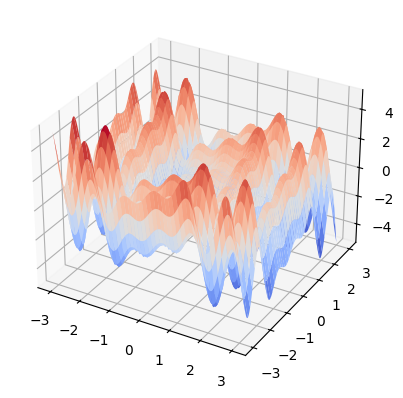

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(gridX[..., 0], gridX[..., 1], gridy, cmap=cm.coolwarm)

## Hparam Opt

In [10]:
HPARAM_KEY = jax.random.PRNGKey(0)
ntrials = 30
nfolds = 5

In [11]:
diag_min, diag_max = 1e-4, 1e1
lr_min, lr_max = 1e-3, 5e-1
epoch_min, epoch_max = 1000, 2500
dropout_min, dropout_max = 0.0, 0.3

search_space = {
    "lrrbf": {
        "lr": (lr_min, lr_max),
        "epochs": (epoch_min, epoch_max),
    },
    "lrgp": {
        "lr": (lr_min, lr_max),
        "epochs": (epoch_min, epoch_max),
        "dropout": (dropout_min, dropout_max),
    },
    "svgp": {
        "lr": (lr_min, lr_max),  # modified based on observation
        "epochs": (epoch_min, epoch_max),
    },
    "periodic": {
        "lr": (lr_min, lr_max),  # modified based on observation
        "epochs": (epoch_min, epoch_max),
    },
}

static = {
    "lrrbf": {
        "diag": 1e-4,
        "R": 100,
        "init_ls": True
    },
    "lrgp": {
        "diag": 1e-4,
        "R": 100,
        "init_ls": True
    },
    "svgp": {
        "diag": 1e-4,
        "R": 100,
        "init_ls": True,
        "kernel": "rbf"
    },
    "periodic": {
        "diag": 1e-4,
        "R": 100,
        "init_ls": True,
        "kernel": "periodic"
    },
}

#### Low Rank RBF

In [15]:
lrrbf_study = fitgp_hparams(
    HPARAM_KEY, build_train_lrrbf, X_train, y_train, nfolds=5, ntrials=ntrials,
    search_space=search_space["lrrbf"], **static["lrrbf"]
)

[I 2024-03-09 14:07:59,475] A new study created in memory with name: no-name-b2de5d6b-3085-44be-8ac4-e2dfcb8c5752
[I 2024-03-09 14:08:45,042] Trial 0 finished with value: 1.3410141794818982 and parameters: {'lr': 0.015885060613062097, 'epochs': 1700}. Best is trial 0 with value: 1.3410141794818982.
[I 2024-03-09 14:09:48,044] Trial 1 finished with value: 1.4494945138830553 and parameters: {'lr': 0.012267754438809259, 'epochs': 2500}. Best is trial 0 with value: 1.3410141794818982.
[I 2024-03-09 14:10:51,618] Trial 2 finished with value: 1.4853276186059299 and parameters: {'lr': 0.008509431763803815, 'epochs': 2500}. Best is trial 0 with value: 1.3410141794818982.
[I 2024-03-09 14:11:43,056] Trial 3 finished with value: 1.467381410472008 and parameters: {'lr': 0.005334326735306611, 'epochs': 2000}. Best is trial 0 with value: 1.3410141794818982.
[I 2024-03-09 14:12:25,988] Trial 4 finished with value: 0.11972538696277175 and parameters: {'lr': 0.17667035606896597, 'epochs': 1600}. Best 

#### Low Rank RFF GP

In [16]:
lrgp_study = fitgp_hparams(
    HPARAM_KEY, build_train_lrgp, X_train, y_train, nfolds=5, ntrials=ntrials * 2,  # more trials as more hparams
    search_space=search_space["lrgp"], **static["lrgp"]
)

[I 2024-03-09 14:32:05,445] A new study created in memory with name: no-name-33f80fae-227e-45b7-a2f6-29a1b20fd442
[I 2024-03-09 14:33:03,263] Trial 0 finished with value: 0.7100018003087354 and parameters: {'lr': 0.001341398658284084, 'epochs': 2100, 'dropout': 0.19426009632729768}. Best is trial 0 with value: 0.7100018003087354.
[I 2024-03-09 14:33:45,477] Trial 1 finished with value: 4.196510717484022e-05 and parameters: {'lr': 0.05543376472211393, 'epochs': 1400, 'dropout': 0.09878797308517485}. Best is trial 1 with value: 4.196510717484022e-05.
[I 2024-03-09 14:34:27,551] Trial 2 finished with value: 0.00010448571021726708 and parameters: {'lr': 0.1517652090740078, 'epochs': 1400, 'dropout': 0.2680630919998197}. Best is trial 1 with value: 4.196510717484022e-05.
[I 2024-03-09 14:35:18,574] Trial 3 finished with value: 7.602402550377845e-05 and parameters: {'lr': 0.020171881175552676, 'epochs': 1800, 'dropout': 0.2859632229565658}. Best is trial 1 with value: 4.196510717484022e-05.


#### SVGP with RBF

In [17]:
svgp_study = fitgp_hparams(
    HPARAM_KEY, build_train_svgp, X_train, y_train, nfolds=5, ntrials=ntrials, 
    search_space=search_space["svgp"], **static["svgp"]
)

[I 2024-03-09 15:30:29,153] A new study created in memory with name: no-name-9f693612-4eae-409f-8803-01871cdd9dc6


[I 2024-03-09 15:30:58,505] Trial 0 finished with value: 2.789268587151864 and parameters: {'lr': 0.028470371728434963, 'epochs': 1500}. Best is trial 0 with value: 2.789268587151864.
[I 2024-03-09 15:31:36,441] Trial 1 finished with value: 2.1990797026372046 and parameters: {'lr': 0.09794445993128567, 'epochs': 2200}. Best is trial 1 with value: 2.1990797026372046.
[I 2024-03-09 15:31:59,590] Trial 2 finished with value: 2.8515411706411085 and parameters: {'lr': 0.0034499080036579665, 'epochs': 1100}. Best is trial 1 with value: 2.1990797026372046.
[I 2024-03-09 15:32:38,927] Trial 3 finished with value: 2.8342667618539195 and parameters: {'lr': 0.003670560188381868, 'epochs': 2300}. Best is trial 1 with value: 2.1990797026372046.
[I 2024-03-09 15:33:13,091] Trial 4 finished with value: 2.8081009504492465 and parameters: {'lr': 0.011668988180615963, 'epochs': 1900}. Best is trial 1 with value: 2.1990797026372046.
[I 2024-03-09 15:33:50,738] Trial 5 finished with value: 2.7306684105520

#### SVGP with Periodic

In [12]:
periodic_study = fitgp_hparams(
    HPARAM_KEY, build_train_svgp, X_train, y_train, nfolds=5, ntrials=ntrials, 
    search_space=search_space["periodic"], **static["periodic"]
)

[I 2024-03-09 16:40:46,208] A new study created in memory with name: no-name-855d0889-f221-4354-9590-29491bf2b004
[I 2024-03-09 16:41:33,786] Trial 0 finished with value: 0.5983358219159184 and parameters: {'lr': 0.029955839402800347, 'epochs': 2400}. Best is trial 0 with value: 0.5983358219159184.
[I 2024-03-09 16:42:09,666] Trial 1 finished with value: 0.5999472177353572 and parameters: {'lr': 0.11059977349355705, 'epochs': 1700}. Best is trial 0 with value: 0.5983358219159184.
[I 2024-03-09 16:42:38,657] Trial 2 finished with value: 0.5972280334802024 and parameters: {'lr': 0.01609255282518116, 'epochs': 1200}. Best is trial 2 with value: 0.5972280334802024.
[I 2024-03-09 16:43:22,567] Trial 3 finished with value: 0.6000345688392746 and parameters: {'lr': 0.08416077149964803, 'epochs': 2300}. Best is trial 2 with value: 0.5972280334802024.
[I 2024-03-09 16:43:58,503] Trial 4 finished with value: 0.6011289222399254 and parameters: {'lr': 0.004499319064809751, 'epochs': 1700}. Best is

## Define Experiment

In [24]:
def experiment(exp_key, N, sr, params, log=True):
    #### PARAMETERS AND SETTINGS    
    logfile = "periodic.pkl"
    exp_key, mc_key = jax.random.split(exp_key)
    d = 2
    bounds = jnp.repeat(jnp.array([[-3., 3.]]), d, axis=0).T
    lb, ub = bounds[0, :], bounds[1, :]

    #### GENERATE DATA
    X = jax.random.uniform(exp_key, (2 * N, d), minval=lb, maxval=ub)
    y = jax.vmap(periodic)(X)
    X_train, X_test, y_train, y_test = train_test(exp_key, X, y, test_size=0.5)

    #### CONVOLUTION SETTINGS
    Nconv = jnp.prod(jnp.asarray(sr_to_N(sr, bounds)))
    Nconv_mc = Nconv if Nconv < 100000 else 100000
    Nconv_lrmc = Nconv if Nconv < 500000 else 500000
    print(f'd: {d}, N: {N}, sr: {sr}, Nconv: {Nconv}')

    #### MEASURES
    mu, sigma = jnp.zeros(d), jnp.ones(d) * 5
    mvn = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    mvn_1d = tfd.Normal(loc=mu, scale=sigma)
    mvu_1d = tfd.Uniform(low=bounds[0, :], high=bounds[1, :])  # uniform
    mvu = tfd.Independent(mvu_1d, reinterpreted_batch_ndims=1)

    measures = [("mvn", mvn, mvn_1d), ("mvu", mvu, mvu_1d)]

    # --------------------------------------- TRAIN GPS -------------------------------------- #
    print("Training GPs...")
    #### SVGP RBF
    svgp, svgp_loss = build_train_svgp(exp_key, X_train, y_train, kernel="rbf", **params["svgp"])
    print(f"SVGP: {svgp_loss[-1]}")

    #### SVGP PERIODIC
    per_gp, per_loss = build_train_svgp(exp_key, X_train, y_train, kernel="periodic", **params["periodic"])
    print(f"Periodic: {per_loss[-1]}")
    
    #### SSGP RBF
    lr_rbf, lr_rbf_loss = build_train_lrrbf(exp_key, X_train, y_train, **params["lrrbf"])
    print(f"SSGP-RBF: {lr_rbf_loss[-1]}")

    #### SSGP RFF
    lrgp, lrgp_loss = build_train_lrgp(exp_key, X_train, y_train, **params["lrgp"])
    print(f"SSGP-RFF GP: {lrgp_loss[-1]}")

    #### predictions
    svgp_preds = svgp.condition(y_train, X_test)[0]
    lr_rbf_preds = lr_rbf.condition(y_train, X_test)[0]
    lrgp_preds = lrgp.condition(y_train, X_test)[0]
    per_gp_preds = per_gp.condition(y_train, X_test)[0]
    gp_mse = {
        'svgp': float(mse(svgp_preds, y_test)), 
        'lrrbf': float(mse(lr_rbf_preds, y_test)), 
        'lrgp': float(mse(lrgp_preds, y_test)),
        'periodic': float(mse(per_gp_preds, y_test))
    }

    #### Update GPs with testing data
    svgp = eqx.tree_at(lambda t: t.X, svgp, X_test)
    per_gp = eqx.tree_at(lambda t: t.X, per_gp, X_test)
    lr_rbf = eqx.tree_at(lambda t: t.X, lr_rbf, X_test)
    lrgp = eqx.tree_at(lambda t: t.X, lrgp, X_test)
    
    gps = [("rbf", svgp, lr_rbf), ("periodic", per_gp, None), ("rff", None, lrgp)]

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    diag_lrbq = params["bq"]["diag_lr"]
    res = {
            "seed": int(exp_key[0]), "d": d, "N": N, "sr": sr, "Nconv": Nconv,
            "params": params, "sol": sol, "metrics": [], "gp_mse": gp_mse
    }
    
    print("Running BQ...")
    #### MC Integration
    mc_int_mu, mc_int_sd = y_train.mean() * area(bounds), y_train.std() * area(bounds) / jnp.sqrt(N)
    res["metrics"].append({
            "k": None, "m": "mc_int", "conv": None, "mu": mc_int_mu, "sd": mc_int_sd,
        } | metric_bq(sol, mc_int_mu, mc_int_sd)
    )

    for mname, m, m_1d in measures:
        for gpname, gp, sgp in gps:
            print(f"Running BQ with {gpname} gp and {mname} measure.")

            #### Nystrom BQ
            if gp is not None:
                svgp_conv = SVGPConv(m, bounds=bounds)
                svgp_mu, svgp_sd = svgp_conv(gp, y_train, key=mc_key, R=Nconv_lrmc, diag=gp._diag)
                res["metrics"].append({
                        "k": gpname, "m": mname, "conv": "svgp", "mu": svgp_mu, "sd": svgp_sd
                    } | metric_bq(sol, svgp_mu, svgp_sd)
                )
            
            #### SSBQ
            if sgp is not None:
                lrmc_conv = SparseMCConv(m, bounds=bounds)
                lrqmc_mu, lrqmc_sd = lrmc_conv(sgp, y_test, key=mc_key, R=Nconv_lrmc, qmc=True) # diag=diag_lrbq,
                res["metrics"].append({
                        "k": "lr_" + gpname, "m": mname, "conv": "qmc", "mu": lrqmc_mu, "sd": lrqmc_sd
                    } | metric_bq(sol, lrqmc_mu, lrqmc_sd)
                )

    if log:
        log_results(logfile, res)
    
    return res

In [31]:
def multi_seed_run(global_key, N, sr, params, log=True, nruns=10):
    res = []
    run_keys = jax.random.split(global_key, nruns)
    for i in range(nruns):
        print(f"---------------------------------------- RUN {i+1} --------------------------------------- #")
        exp_res = experiment(run_keys[i], N, sr, params, log=log)
        res.extend(exp_res)
        exp_df = pd.DataFrame(exp_res['metrics']).sort_values('mse', ascending=True)
        print(exp_df[['k', 'm', 'conv', 'mse']])
    return res

## Run Experiment

In [26]:
KEY = jax.random.PRNGKey(2024)
R = 100

gp_params = {
    "lrrbf": {
        'R': R, 'ls_init': True, 'diag': 1e-4,
        'lr': 0.07492394298689774, 'epochs': 2000
    },
    "lrgp": {
        'R': R, 'ls_init': True, 'diag': 1e-4,
        'lr': 0.10500330939695285, 'epochs': 2300, 'dropout': 0.017611366700918105
    },
    "svgp": {
        'R': R, 'ls_init': True, 'diag': 1e-4,
        'lr': 0.4897348761550944, 'epochs': 1400
    },
    "periodic": {
        'R': R, 'ls_init': True, 'diag': 1e-4,
        'lr': 0.464890385947804, 'epochs': 1000
    },
    "bq": {'diag': 1e-4, 'diag_lr': 1e-4}
}

In [27]:
run_res = experiment(KEY, N=1000, sr=100, params=gp_params, log=False)

d: 2, N: 1000, sr: 100, Nconv: 360000
Training GPs...
SVGP: 1802964.9852683768
Periodic: 6668560.7031004075
SSGP-RBF: 37668.32382037751
SSGP-RFF GP: -2607.289224749586
Running BQ...
Running BQ with rbf gp and mvn measure.
Running BQ with periodic gp and mvn measure.
Running BQ with rff gp and mvn measure.
Running BQ with rbf gp and mvu measure.
Running BQ with periodic gp and mvu measure.
Running BQ with rff gp and mvu measure.


In [32]:
res_1k = multi_seed_run(KEY, N=1000, sr=100, params=gp_params, log=True, nruns=10)

---------------------------------------- RUN 1 --------------------------------------- #
d: 2, N: 1000, sr: 100, Nconv: 360000
Training GPs...
SVGP: 1436082.1605580896
Periodic: 7898716.259562675
SSGP-RBF: 18406.304292734294
SSGP-RFF GP: -2648.5820494098775
Running BQ...
Running BQ with rbf gp and mvn measure.
Running BQ with periodic gp and mvn measure.
Running BQ with rff gp and mvn measure.
Running BQ with rbf gp and mvu measure.
Running BQ with periodic gp and mvu measure.
Running BQ with rff gp and mvu measure.
          k       m  conv        mse
4    lr_rff     mvn   qmc   0.000065
8    lr_rff     mvu   qmc   0.000080
2    lr_rbf     mvn   qmc   0.109445
6    lr_rbf     mvu   qmc   0.115778
0      None  mc_int  None  12.616617
7  periodic     mvu  svgp  13.465618
3  periodic     mvn  svgp  13.694044
5       rbf     mvu  svgp  17.291275
1       rbf     mvn  svgp  18.339593
---------------------------------------- RUN 2 --------------------------------------- #
d: 2, N: 1000, sr: 

In [48]:
res_5k = multi_seed_run(KEY, N=5000, sr=100, params=gp_params, log=True, nruns=10)

---------------------------------------- RUN 1 --------------------------------------- #
d: 2, N: 5000, sr: 100, Nconv: 360000
Training GPs...
SVGP: 5477595.115178168
Periodic: 40475943.63445026
SSGP-RBF: 26196.72981028552
SSGP-RFF GP: -14175.544332636258
Running BQ...
Running BQ with rbf gp and mvn measure.
Running BQ with periodic gp and mvn measure.
Running BQ with rff gp and mvn measure.
Running BQ with rbf gp and mvu measure.
Running BQ with periodic gp and mvu measure.
Running BQ with rff gp and mvu measure.
          k       m  conv       mse
8    lr_rff     mvu   qmc  0.000018
4    lr_rff     mvn   qmc  0.000020
2    lr_rbf     mvn   qmc  0.012884
6    lr_rbf     mvu   qmc  0.015868
3  periodic     mvn  svgp  0.146820
1       rbf     mvn  svgp  0.160935
7  periodic     mvu  svgp  0.167256
5       rbf     mvu  svgp  0.243274
0      None  mc_int  None  0.281602
---------------------------------------- RUN 2 --------------------------------------- #
d: 2, N: 5000, sr: 100, Nconv: 

## Evaluate

In [10]:
import pandas as pd
import pickle
import numpy as np

In [25]:
res = pd.read_pickle("periodic.pkl")

gp_mses = []
metrics = []
for r in res:
    res_metrics = r["metrics"]
    exp_info = {"d": r["d"], "N": r["N"], "sr": r["sr"]}
    res_metrics = [rm | exp_info for rm in res_metrics]
    metrics.extend(res_metrics)
    gp_mses.append(exp_info | r["gp_mse"])

In [26]:
# BQ metrics
metrics = pd.DataFrame(metrics)
metrics[['k', 'conv']] = metrics[['k', 'conv']].fillna('mc_int')
metrics['rmse'] = np.sqrt(metrics['mse'])
sum_df = metrics.groupby(['k', 'm', 'conv', 'N'])['rmse'].mean().reset_index().sort_values('rmse', ascending=True)
sum_df_sd = metrics.groupby(['k', 'm', 'conv', 'N'])['rmse'].std().reset_index()
sum_df_sd['rmse_std'] = sum_df_sd['rmse']
sum_df_sd = sum_df_sd.drop(columns='rmse')
sum_df = sum_df.merge(sum_df_sd, on=['k', 'm', 'conv', 'N'])

# GP MSE metrics
gp_mses = pd.DataFrame(gp_mses)
sum_gp_mses = gp_mses.groupby(['N']).mean().reset_index()

In [47]:
sum_gp_mses

,N,d,sr,svgp,lrrbf,lrgp,periodic
0,1000,2.0,100.0,0.104212,0.026396,0.000006,0.605881
1,5000,2.0,100.0,0.067313,0.117269,0.000003,0.558321


In [50]:
jnp.sqrt(jnp.asarray([0.067313, 0.117269])).round(decimals=3)

Array([0.259, 0.342], dtype=float64)

In [27]:
sum_df

,k,m,conv,N,rmse,rmse_std
0,lr_rff,mvn,qmc,5000,0.015260,0.011245
1,lr_rff,mvu,qmc,5000,0.016388,0.012230
2,lr_rff,mvn,qmc,1000,0.022177,0.017211
3,lr_rff,mvu,qmc,1000,0.023458,0.018157
4,lr_rbf,mvn,qmc,5000,0.164645,0.129063
5,lr_rbf,mvu,qmc,5000,0.177423,0.134865
6,lr_rbf,mvn,qmc,1000,0.475350,0.197211
7,lr_rbf,mvu,qmc,1000,0.514317,0.241540
8,mc_int,mc_int,mc_int,5000,0.647544,0.676859
9,periodic,mvu,svgp,5000,0.650939,0.678026


In [30]:
paper_tab = sum_df[
    ((sum_df['conv'] == 'svgp') & (sum_df['m'] == 'mvu')) |
    ((sum_df['k'] == 'lr_rff') & (sum_df['m'] == 'mvn')) | 
    ((sum_df['k'] == 'lr_rbf') & (sum_df['m'] == 'mvn')) |
    (sum_df['m'] == 'mc_int')
].drop(columns=['m', 'conv'])

In [35]:
paper_tab_mu = paper_tab.pivot(index='k', columns='N', values='rmse')
paper_tab_sd = paper_tab.pivot(index='k', columns='N', values='rmse_std')

rmse_cols = [paper_tab_mu[col].apply(
    lambda x: f"{x:.2f}") + " $\pm$ " + paper_tab_sd[col].apply(lambda x: f"{x:.2f}"
) for col in paper_tab_mu.columns]

In [43]:
rmse_df = pd.DataFrame([paper_tab_mu.index, *rmse_cols]).T
rmse_df.columns = ["model", "$N=1000$, $R=100$", "$N=5000$, $R=100$"]

names = {
    "lr_rbf": "SSBQ-RBF",
    "lr_rff": "SSBQ-RFF",
    "mc_int": "MC",
    "periodic": "SVGP-$\sin^2$",
    "rbf": "SVGP-RBF",
}

rmse_df["model"] = rmse_df["model"].apply(lambda x: names[x])

In [46]:
print(rmse_df.to_latex(index=False, escape=False))

\begin{tabular}{lll}
\toprule
model & $N=1000$, $R=100$ & $N=5000$, $R=100$ \\
\midrule
SSBQ-RBF & 0.48 $\pm$ 0.20 & 0.16 $\pm$ 0.13 \\
SSBQ-RFF & 0.02 $\pm$ 0.02 & 0.02 $\pm$ 0.01 \\
MC & 1.36 $\pm$ 1.24 & 0.65 $\pm$ 0.68 \\
SVGP-$\sin^2$ & 1.72 $\pm$ 1.24 & 0.65 $\pm$ 0.68 \\
SVGP-RBF & 1.59 $\pm$ 1.44 & 0.65 $\pm$ 0.70 \\
\bottomrule
\end{tabular}



N,1000,5000
k,,
lr_rbf,0.475350,0.164645
lr_rff,0.022177,0.015260
mc_int,1.364134,0.647544
periodic,1.715623,0.650939
rbf,1.587193,0.652625


## Dev

In [15]:
from ffbq.conv import SVGPConv
from ffbq.sparse_conv import SparseMCConv
from ffbq.gp.kernels import Periodic
from ffbq.gp.gp import SVGP

In [16]:
svgp = build_svgp(
    KEY, X_train, R=100, diag=1e-6, kernel="periodic", init_ls=True
)

In [17]:
svgp.kernel.kernel._gamma

Array(1., dtype=float64, weak_type=True)

In [28]:
svgp.nll(y_train)

Array(1.27875184e+15, dtype=float64)

In [18]:
svgp, _ = build_train_svgp(
    KEY, X_train, y_train, lr=0.1, epochs=1000, R=100, diag=1e-4, kernel="periodic"
)
svgp_preds, svgp_sd = svgp.condition(y_train, X_test)

In [24]:
lrgp_params = {'R': 100,
    'ls_init': True,
    'diag': 0.0001,
    'lr': 0.0072802711657805,
    'epochs': 1500,
    'dropout': 0.23296000503024086
}

lrgp, _ = build_train_lrgp(
    KEY, X_train, y_train, **lrgp_params, #**gp_params['lrgp'],
    to_train= lambda t: [t.kernel.kernel.w, t.kernel.transform.scale, t.diag]
)
lrgp_preds, lrgp_sd = lrgp.condition(y_train, X_test)

In [25]:
mse(y_test, svgp_preds), mse(y_test, lrgp_preds)

(Array(0.12646555, dtype=float64), Array(0.20640982, dtype=float64))

In [27]:
mvu = tfd.Independent(tfd.Uniform(low=bounds[0, :], high=bounds[1, :]), reinterpreted_batch_ndims=1)

In [68]:
lrgp_conv = SparseMCConv(mvu, bounds=bounds)
lrgp_mu, lrgp_sd = lrgp_conv(lrgp, y_test, key=KEY, R=600**2, qmc=True)

In [69]:
svgp_conv = SVGPConv(mvu, bounds=bounds)
svgp_mu, svgp_sd = svgp_conv(svgp, y_train, key=KEY, R=600**2, diag=svgp._diag)

In [70]:
svgp_mu, lrgp_mu

(Array(-0.10885672, dtype=float64), Array(0.34222693, dtype=float64))

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# ax.view_init(90, 0)
# ax.plot_surface(gridX[..., 0], gridX[..., 1], gridy, cmap=cm.coolwarm, alpha=0.5)
# # ax.scatter(X_train[..., 0], X_train[..., 1], y_train, c='r', marker='o', s=3)
# ax.scatter(svgp.m[..., 0], svgp.m[..., 1], jnp.ones(svgp.m.shape[0]) * 5, c='r', marker='o', s=3)